## Training a model and making predictions

In order to train and optimize VAESIMCA model, first we need to define encoder and decoder classes for the Variational Autoencoder. The classes must inherit `torch.nn.Module` class and the constructor must have two parameters: `img_size` — which is a tuple with image width, height and number of channels, and `latent_dim` — the desired dimension of the latent space.

Here is an example of simple encoder and decoder similar to what have been used in the examples from the paper:

In [1]:
# load all packages needed to run the code in this notebook
import matplotlib.pyplot as plt

from torchvision import transforms
from torch import nn, sigmoid
from torch.nn import functional as F
from vaesimca import VAESIMCA

/home/svkucheryavski/.local/lib/python3.12/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:

# define the encoder class
class Encoder(nn.Module):
    def __init__(self, img_size, latent_dim):
        super(Encoder, self).__init__()
        img_width, img_height, nchannels = img_size
        self.conv1 = nn.Conv2d(nchannels, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(256 * (img_width // 16) * (img_height // 16), latent_dim)
        self.fc_logvar = nn.Linear(256 * (img_width // 16) * (img_height // 16), latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1) # flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# define the decoder class
class Decoder(nn.Module):
    def __init__(self, img_size, latent_dim):
        super(Decoder, self).__init__()
        img_width, img_height, nchannels = img_size
        self.img_width = img_width
        self.img_height = img_height
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, 256 * (img_width // 16) * (img_height // 16))
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, nchannels, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 256, (self.img_width // 16), (self.img_height // 16))
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        z = sigmoid(self.deconv4(z))
        return z


The next step is to define a sequence of transformations for the images. This sequence should at least include the resizing (to ensure that all images have the same size) and normalization to [0, 1] range which can be done by simply applying `toTensor()` transformation. Here is an example:

In [3]:
# define tuple with image size (width, height, number of channels)
img_size = (128, 128, 1)

# define transformations
transform = transforms.Compose([
    transforms.Resize([img_size[0], img_size[1]]),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In the code above we also set `img_size` value for the simulated images.

After that you need to define path to the training set. The directory should contain an image folder whose name will be the same as a target class name you want to train the model for. If the directory also contains other folders, they will be ignored.

In [ ]:
# path to directory with training sets
train_path = "images_simulated/train"

# class name (directory with this name should be in the training path)
classname = "target"

Now we can initialize and train the model (here in all examples the number of epochs is relatively small to make computation faster):

In [ ]:
# model and training parameters
latent_dim = 6
nepochs = 30
lr = 0.0001

# initialize the model object
m = VAESIMCA(encoder_class=Encoder, decoder_class=Decoder, classname = classname,
                img_size=img_size, latent_dim=latent_dim, transform=transform)

# train the model
m.fit(data_path=train_path, nepochs=nepochs, lr = lr)

As you can see, by default the learning rate is getting smaller every 10 epochs. This can be changed by providing corresponding parameters, `scheduler_step_size` (by default is 10, meaning change learning rate after each 10 epochs) and `scheduler_gamma` (by default 0.5 meaning decrease the rate by half).

The `train()` method has another argument, `verbose`, which is by default set to `True`. In this case the training process will provide some information every 10 epochs (the training lost). To suppress this simply set the parameter to `False`:

In [ ]:
# train the model without output
m.fit(data_path=train_path, nepochs=nepochs, lr = lr, verbose = False)

The method `fit()` also has several other parameters which can influence the training process, including `beta` — regularisation factor for computing total loss, batch size, etc. Check help for the `fit()` method for more details.

Once the model is trained one can start using it to make predictions for other images. Here is an example how to make predictions for the training set and for the test set which contains three classes (`target`, `alt1`, `alt2`):

In [ ]:

# make predictions and show summary for training set
rc = m.predict(data_path=train_path)
rc.summary()

In [ ]:
# make predictions and show summary for test set located in a separate folder
test_path = "images_simulated/test"
rt = m.predict(data_path=test_path)
rt.summary()

By default the predictions are made based on the full distance values. You can change this by providing additional parameter, `distance`, which can be set to `f` (full distance, default value), `q` (residual distance) and `h` (explained distance):

In [ ]:
rt = m.predict(data_path=test_path, distance="q")
rt.summary()

The `predict()` method returns the `VAESIMCARes` object which contains all outcomes: distances, scores, etc. It has several methods which let you assess the performance of the model. For each class found in the directory `data_path`, it simply computes the number of objects which were accepted by the model as target class members (`in`) or rejected as strangers (`out`).

Method `summary()` prints this information a readable way, but it can also be obtained as a dictionary by using method `stat()`:

In [ ]:
# get results of classification for each class as a dictionary
s = rt.stat()
print(s)

By default the prediction is made for significance level of 0.05, which means that 5% of target class members will be rejected (in theory), so the expected sensitivity of the model is 0.95. This can be changed by providing additional parameter to the predict method:

In [ ]:
# make predictions using decision boundary computed for SL = 0.01
rt2 = m.predict(data_path=test_path, alpha = 0.01)
rt2.summary()

The results can also be visualized using two plots. The first is the *Distance plot*, which shows the distance values in form of bar plots:

In [ ]:

plt.figure(figsize=(10, 10), dpi = 150)

plt.subplot(3, 1, 1)
rt.plotDistance(plt, distance="h")

plt.subplot(3, 1, 2)
rt.plotDistance(plt, distance="q")

plt.subplot(3, 1, 3)
rt.plotDistance(plt, distance="f")

For each distance you can show the statistical boundaries (for detection of extreme objects and outliers) as well as the object labels:

In [ ]:
plt.figure(figsize=(10, 10), dpi = 200)

plt.subplot(3, 1, 1)
rt.plotDistance(plt, distance="h", show_boundaries=True)

plt.subplot(3, 1, 2)
rt.plotDistance(plt, distance="q", show_boundaries=True)

plt.subplot(3, 1, 3)
rt.plotDistance(plt, distance="f", show_boundaries=True, show_labels=True)

The second is the *Acceptance plot*, which shows the scaled explained and residual distances in form of a scatter plot together with the decision boundary. It is also possible to show the object labels and use log-transformed distance values, which are in general improve the plot readability:

In [ ]:
plt.figure(figsize=(10, 5), dpi = 150)

plt.subplot(1, 2, 1)
rt.plotAcceptance(plt)
plt.subplot(1, 2, 2)
rt.plotAcceptance(plt, dolog = True)

In both plots, user can modify colors used to show outcomes of each class as well as the markers in case of the acceptance plot. Check the documentation of the methods for details.

Finally one can get full set of results including object labels, distances, decision etc. as a data frame:

In [ ]:
res_df = rt.as_df()
print(res_df)


Here the `decision` column is logical, `True` if object was accepted as a member of the target class by the model and `False` if it was rejected. Same about the `outlier` object. The sample labels are image file names without the extension.

Finally, you can also plot the reconstruction error for an image with given label from a given class (you need to specify both to avoid possible ambiguity as images in different folders may have the same names):

In [ ]:
plt.subplot(2, 2, 1)
rt.plotError(plt, classname = "target", object_label="t64")
plt.subplot(2, 2, 2)
rt.plotError(plt, classname = "target", object_label="t14")
plt.subplot(2, 2, 3)
rt.plotError(plt, classname = "alt1", object_label="a64")
plt.subplot(2, 2, 4)
rt.plotError(plt, classname = "alt2", object_label="a64")


## Optimization of the model parameters

The `VAESIMCA` class has a static method `gridsearch()` which simplifies optimization of four main parameters: the dimension of the latent space (`ld`), the learning rate (`lr`), the batch size (`bs`) and the regularization parameter (`beta`). It requires both training and test set for the optimization as well as other components and settings necessary to train the `VAESIMCA` model: encoder and decoder classes, transformation function, number of epochs, etc.

By default it runs optimization for each combination of parameters three times (three iterations), but this can be changed.

Here is an example, where it trains the models for different combination of the parameters and returns results in form of a data frame which contains the learning parameters and number and percent of objects in each class that was accepted by the corresponding model. During each iteration it shows progress bar as well as best sensitivity, specificity and efficiency achieved. At the end it shows parameters which gave the best sensitivity, specificity and efficiency overall:

In [ ]:
# gridsearch example — !!! note it will take time to run this code !!!

train_path = "images_simulated/train"
test_path = "images_simulated/test"
classname = "target"
img_size = (128, 128, 1)

nepochs = 30
lr_seq = [10E-4, 1E-5]
ld_seq = [8, 16]
bs_seq = [10, 20]
beta_seq = [0.5, 1]

res = VAESIMCA.gridsearch(
    train_path=train_path, test_path=test_path, classname = classname, img_size=img_size, transform=transform,
    encoder_class=Encoder, decoder_class=Decoder,
    lr_seq=lr_seq, ld_seq=ld_seq, bs_seq=bs_seq, beta_seq=beta_seq,
    nepochs=nepochs
)

Here we reuse the encoder/decoder classes and transformation function from the examples above. If you just need the results you can suppress the output by providning parameter `verbose = False`.

Here how the returned results look like:

In [ ]:
print(res)

The results can be then combined to get overall statistics for each combination of the parameters, for example:

In [ ]:
import pandas as pd

# Function to compute sensitivity and specificity for test set only
def compute_metrics(df):
    metrics = []

    # Filter the dataframe to include only the test set
    test_df = df[df['set'] == 'test']

    # Group by unique combinations of the parameters
    grouped = test_df.groupby(['comb', 'beta', 'bs', 'lr', 'ld'])

    for name, group in grouped:
        # Extract target class information
        target_group = group[group['class'] == 'target']
        alt_group = group[group['class'] != 'target']

        # Calculate sensitivity
        sensitivity = target_group['in'].sum() / target_group['n'].sum()

        # Calculate specificity
        specificity = (alt_group['n'].sum() - alt_group['in'].sum()) / alt_group['n'].sum()

        # Append the results
        metrics.append({
            'comb': name[0],
            'beta': name[1],
            'bs': name[2],
            'lr': name[3],
            'ld': name[4],
            'sensitivity': sensitivity,
            'specificity': specificity
        })

    return pd.DataFrame(metrics)

stat = compute_metrics(res)
print(stat)



In [ ]:
grouped_specificity = stat.groupby('ld')['specificity'].apply(list)

# Create the box plot using matplotlib
plt.figure(figsize=(12, 6))
plt.boxplot(grouped_specificity, labels=grouped_specificity.index)
plt.title('Specificity vs. LD')
plt.xlabel('LD')
plt.ylabel('Specificity')
plt.show()

## Working with CSV files

From version *0.4.0* it is possible to provide data values in form of CSV files, so every row is an image. CSV file must have row labels (e.g. image names), and class labels as the first column. The other columns should contain the image intensity values as unsigned integer numbers between 0 and 255, flatten as follows:

```python
 row_values = np.array(image).astype(np.uint8).reshape(-1)
```

Here `image` is PIL Image object.

In this case, simply change path to training and test sets, so they are pointing on CSV file instead of image folders, and the rest will work automatically. There are two files available in the `demo` folder, which were created based on the simulated data. So here is an example:

In [ ]:
# path to directory with training sets as CSV file
train_path = "images_simulated_train.csv"
classname = "target"

latent_dim = 6
nepochs = 30
lr = 0.0001

# initialize the model object
m = VAESIMCA(encoder_class=Encoder, decoder_class=Decoder, classname = classname,
                img_size=img_size, latent_dim=latent_dim, transform=transform)

# train the model
m.fit(data_path=train_path, nepochs=nepochs, lr = lr)

In [ ]:
# make predictions and show summary for test set located in another CSV file
test_path = "images_simulated_test.csv"
rt = m.predict(data_path=test_path)
rt.summary()

## Learning rate finder

Another option available from v. 0.4.0 is integration with [learning rate finder]() package. Here are some examples: 

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.58E-04


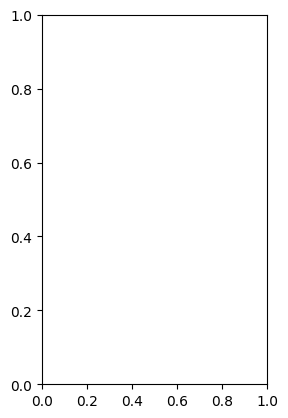

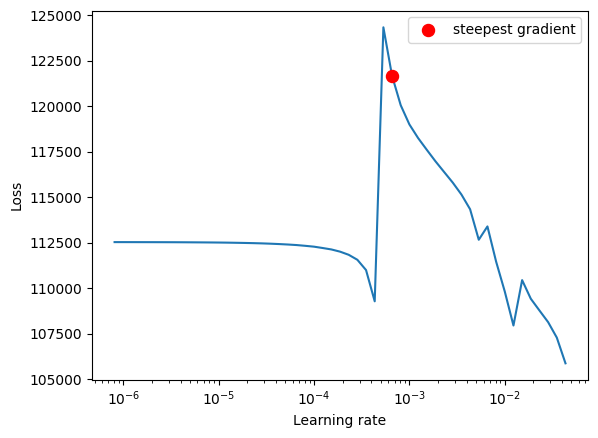

<Axes: >

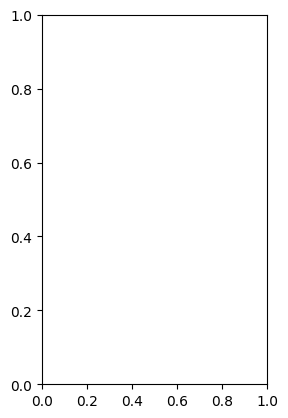

In [ ]:
# same settings
train_path = "images_simulated/train"
test_path = "images_simulated/test"
classname = "target"
latent_dim = 6

# initialize the model object
m = VAESIMCA(encoder_class=Encoder, decoder_class=Decoder, classname = classname,
                img_size=img_size, latent_dim=latent_dim, transform=transform)

# run LR finder using tweaked version from fastai (default option)
lrf = m.findlr(data_path=train_path, method = "other")

# compare the outcomes
lrf.plot()
